# Генератор данных для задач классификации

В этом блокноте рассматривается задача о классификации набора векторов. Под каждым вектором мы понимаем строго фиксированную по порядку совокупность признаков, числового типа. Каждая такая совокупность характеризует состояние исследуемой системы в определенный момент времени измерений. Предполагаемая система может находиться в трех состояниях. Поэтому исследуемый набор векторов строго разделяется на три класса. В качестве примера такой системы рассмотрим процесс фиксации электро-энцефалограммы (ЭЭГ) мозга. При фиксации ЭЭГ эксперт отмечает характерные временные участки, на которых электрический сигнал ЭЭГ имеет определенную частоту колебаний, отражающих ритмическую активность внутренних процессов в мозге. (Такие ритмы еще принято называть осцилляторными структурами.) Эксперт в зависимости от исследуемой проблемы может по-разному объединять эти активности в разные классы, отмечая те или иные колебания на записи ЭЭГ. На каждой такой отмеченной записи может присутствовать от одной до нескольких осцилляторных структур и фоновых шумов.

Установлены четыре наиболее доминантные ритмические активности: дельта, тетта, альфа и бетта.
Мы будем рассматривать три класса состояний мозга на ЭЭГ по соответствующим ритмам:<br>
1) фоновая слабовыраженная активность: суммарынй набор ритмов дельта, тетта, альфа и бетта<br>
2) сильно выраженная бетта-активность (высокие частоты): бетта ритм<br>
3) сильно выраженная альфа-активность (средние частоты): альфа ритм<br>

Каждый отдельно взятый ритм может быть описан колебательным процессом (например семейством функций sin/cos) c центральной частотой и дополнительными суб-гармониками. Под каждый ритм принято отводить диапазон частот. Таблица диапазонов частот ЭЭГ хорошо известна (на четыре указанных ритма выделяется спектральный диапазон от 0 до 30 Гц). Мы рассматриваем одноканальную запись ЭЭГ, на которой эксперт размечает все три состояния (1,2,3) как три вышеописанных класса активностей.<br>

Одноканальный ЭЭГ-сигнал в виде временного ряда мы преобразуем в набор векторов на основе преобразования Фурье со скользящим временным окном. Значения самого сигнала для нас не представляют особой ценности, а вот мгновенное состояние спектра как результат Фурье преобразования в каждой временной точке сигнала - это и будет информация для комплектации набора векторов. Эксперт при разметке определил три класса, следовательно мы анализируем 3 разных набора дискретизованных спектров. Дискретизованный спектр мы соотносим с вектором при решении задачи классификации состояний классам 1, 2 и 3. Будем рассматривать спектр от 1 до 50 Гц с дискретизацией 1 Гц, поэтому вектор будет иметь 50 координат. Ниже приведен код, который эмулирует опыт с ЭЭГ и дает соответствующую разбивку векторов по классам 1, 2 и 3.

In [192]:
import numpy as np
import math
import random
import pandas as pd



# additional functions:---------------------------------------------
def rand_int_array(low,high,size):
    return np.array(np.random.randint(low=low,high=high,size=size,dtype=int));

def rand_flt_array (low,high,size):
    return (high - low) * np.random.sample(size) + low


# The main settings store class:------------------------------------
class SettingsStore:
    
    def __init__ (self,delta_t,q_sample,t_min,t_max):
        self.delta_t = delta_t;
        self.q_sample = q_sample;
        self.t_min = t_min;
        self.t_max = t_max;
        self.relation_tau_pointers = rand_int_array(low=self.t_min, high=self.t_max, size=self.q_sample);
        self.q_points = self.relation_tau_pointers.sum();
        self.tau_pointers = None;
    
   
    def init_tau_pointers(self):
        self.tau_pointers = np.array([],dtype=int);
        
        sum = 0;
        for relation_tau_pointer in self.relation_tau_pointers:
            sum += relation_tau_pointer;
            self.tau_pointers = np.append(self.tau_pointers,int(sum));
            
        assert(sum==self.q_points);
        print ("  --> Settings store post construct completed {}".format(self));
        return self;
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__);

    
# The class of EEG frequencies set definition:----------------------
class EegFreqs:
    
    def __init__ (self,freq_size):
        self.__delta_freqs = rand_flt_array(low=1,high=5,size=freq_size);
        self.__theta_freqs = rand_flt_array(low=4,high=8,size=freq_size);
        self.__alpha_freqs = rand_flt_array(low=7,high=15,size=freq_size);
        self.__betta_freqs = rand_flt_array(low=14,high=31,size=freq_size);
       
    def delta(self):
        return np.random.choice(self.__delta_freqs);
    def theta(self):
        return np.random.choice(self.__theta_freqs);
    def alpha(self):
        return np.random.choice(self.__alpha_freqs);
    def betta(self):
        return np.random.choice(self.__betta_freqs);
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__);

    
# The class of EEG sin wave generators:-----------------------------
class EegGenerators:
    
    def __init__(self,eeg_freqs,settings,phase_scale,noise_ratio):
        self.__eeg_freqs = eeg_freqs;
        self.__settings = settings;
        
        self.__generator_cnt = 0;
        self.__phase_scale = phase_scale;
        self.__phase = 0.0;
        self.__noise_ratio = noise_ratio;
        self.__delta = eeg_freqs.delta();
        self.__theta = eeg_freqs.theta();
        self.__alpha = eeg_freqs.alpha();
        self.__betta = eeg_freqs.betta();
            
    def generate_background(self,i):
        xtr = self.__delta_signal(i);
        xtr += self.__theta_signal(i);
        xtr += self.__alpha_signal(i);
        xtr += self.__betta_signal(i);
        xtr += self.__noise_signal()
        return xtr;
    
    def generate_alpha(self,i):
        return 4.0*self.__alpha_signal(i)+self.__noise_signal();
    
    def generate_betta(self,i):
        return 4.0*self.__betta_signal(i)+self.__noise_signal();
        
    def __delta_signal(self,i):
        self.__control_generating();
        return self.__sin(self.__delta,i);
    
    def __theta_signal(self,i):
        self.__control_generating();
        return self.__sin(self.__theta,i);
    
    def __alpha_signal(self,i):
        self.__control_generating();
        return self.__sin(self.__alpha,i);
    
    def __betta_signal(self,i):
        self.__control_generating();
        return self.__sin(self.__betta,i);
            
    def __sin (self, freq, index):
        return math.sin(2*math.pi*self.__settings.delta_t*freq*index+self.__phase);
    
    def __noise_signal(self):
        return random.gauss(mu=0, sigma=self.__noise_ratio)
    
    def __reset_phase (self):
        self.__phase = random.random()*math.pi;
        self.__delta = self.__eeg_freqs.delta();
        self.__theta = self.__eeg_freqs.theta();
        self.__alpha = self.__eeg_freqs.alpha();
        self.__betta = self.__eeg_freqs.betta();
        return self;
    
    def __control_generating (self):
        if self.__generator_cnt>=self.__phase_scale:
            self.__generator_cnt=0;
            self.__reset_phase();
        self.__generator_cnt+=1;
    
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__);
        

# The main EEG waves array producer:--------------------------------
class EegWaves:
    
    def __init__ (self, settings,eeg_generators):
        self.signal=np.zeros(shape=(settings.q_points));
        self.indicator_signal=np.ndarray(shape=(2,settings.q_points),dtype=int);
        self.target_signal=np.zeros(shape=(settings.q_points));
        self.__settings = settings;
        self.__eeg_generators = eeg_generators;

    def make_waves(self):
        print("     > Launched making waves...")
        
        Qps = self.__settings.q_points;
        gen = self.__eeg_generators.generate_background;
        for i in range(0,Qps):
            self.signal[i] = gen(i);
            self.indicator_signal[0][i] = 0;
            self.indicator_signal[1][i] = 0;
            self.target_signal[i] = 1;
        print("     > Generating background was completed");
        
        Qs = self.__settings.q_sample;
        tau = self.__settings.tau_pointers;
        for j in range(0,Qs-1,2):
            select = self.__signal_selector();
            for i in range(tau[j],tau[j+1]):
                self.signal[i]=self.__generate_wave(select,i);
                self.indicator_signal[select][i]+=1;
                self.target_signal[i]+=(select+1);
        
        print("     > Made waves: {}".format(self));
        return self;
                
    def __generate_wave(self,selector,i):
        if selector==1:
            return self.__eeg_generators.generate_alpha(i);
        else:
            return self.__eeg_generators.generate_betta(i);
                
    def __signal_selector(self):
        if random.random()>0.5:
            return 1;
        else :
            return 0;
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__);
        


In [193]:
#--------------------------------------------------------------------------------------
# Launching:---------------------------------------------------------------------------
random.seed(19121988);
np.random.seed(19121988);

settings = SettingsStore(delta_t=0.01,q_sample=200,
                         t_min=500,t_max=1000).init_tau_pointers();

eeg_freqs = EegFreqs(freq_size=20);
print("  --> EEG frequencies: {}".format(eeg_freqs));

eeg_generators = EegGenerators(eeg_freqs=eeg_freqs,settings=settings,
                               phase_scale=2000,noise_ratio=0.65);
print("  --> EEG generators: {}".format(eeg_generators));

eeg_waves = EegWaves(settings=settings,
                     eeg_generators=eeg_generators).make_waves();

#--------------------------------------------------------------------------------------

  --> Settings store post construct completed <class '__main__.SettingsStore'>: {'delta_t': 0.01, 'q_sample': 200, 't_min': 500, 't_max': 1000, 'relation_tau_pointers': array([786, 698, 835, 888, 785, 899, 993, 536, 677, 680, 932, 604, 834,
       802, 634, 544, 788, 524, 512, 556, 550, 590, 633, 546, 760, 543,
       794, 832, 839, 647, 841, 529, 609, 549, 920, 849, 998, 981, 598,
       814, 883, 780, 862, 561, 840, 686, 897, 680, 947, 617, 906, 937,
       580, 578, 596, 934, 727, 757, 890, 576, 586, 599, 646, 603, 914,
       966, 651, 969, 642, 995, 605, 702, 738, 673, 583, 904, 876, 651,
       670, 843, 750, 523, 941, 811, 760, 632, 790, 926, 764, 693, 657,
       919, 999, 887, 971, 818, 714, 543, 685, 927, 808, 755, 831, 561,
       542, 819, 531, 729, 948, 639, 691, 604, 814, 589, 734, 663, 881,
       808, 760, 714, 800, 700, 632, 672, 884, 890, 756, 763, 692, 973,
       753, 657, 935, 750, 689, 906, 770, 814, 593, 643, 729, 938, 773,
       929, 669, 624, 505, 524, 573, 78

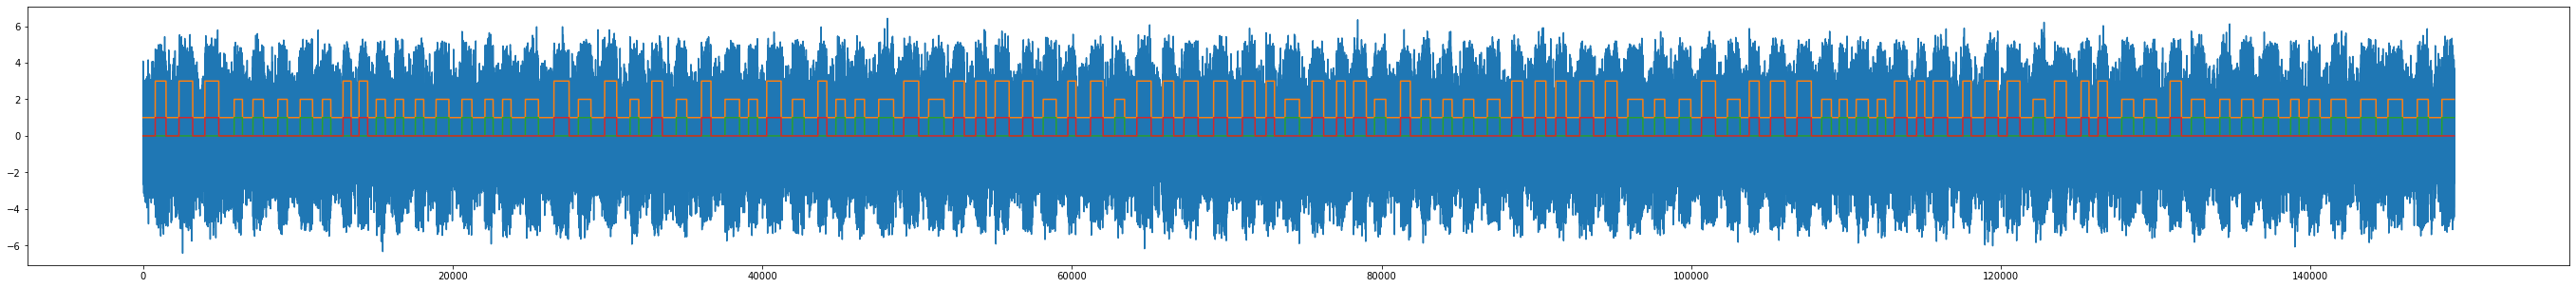

In [194]:
import matplotlib.pyplot as plt

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 48,5

# Plotting signal:----------------------------------------------------
plt.plot(eeg_waves.signal);

# Plotting target signal:---------------------------------------------
plt.plot(eeg_waves.target_signal);

# Plotting EXPERT marker signal:--------------------------------------
plt.plot(eeg_waves.indicator_signal[0]);
plt.plot(eeg_waves.indicator_signal[1]);


  --> The Fourier image was calculated: shape=(149270,)


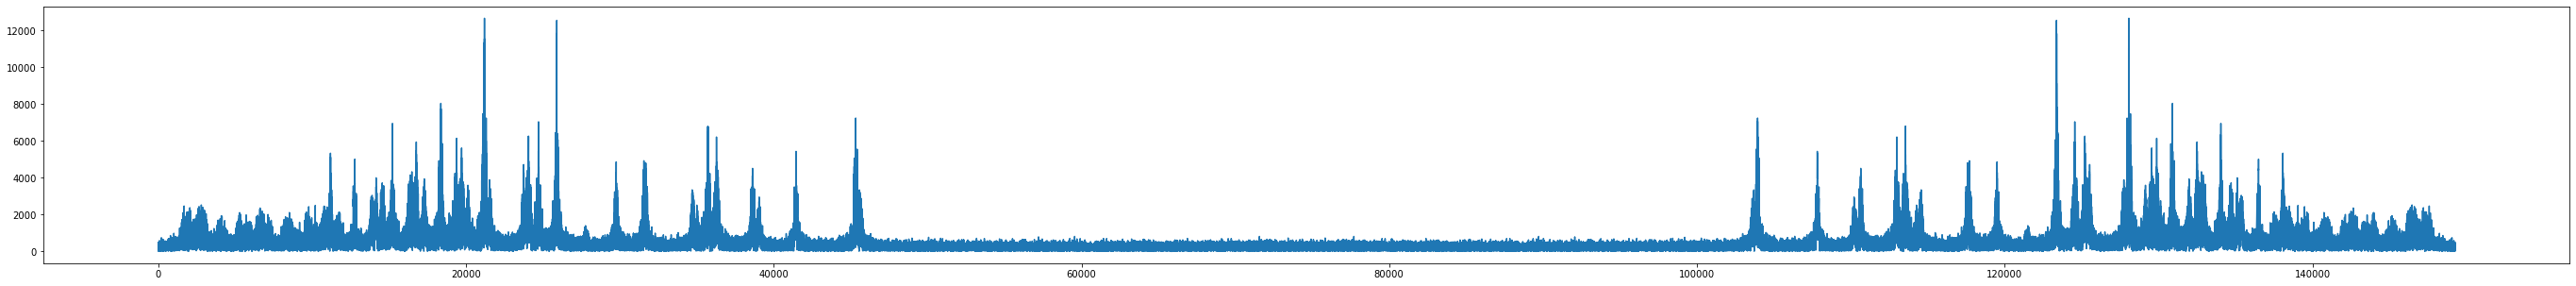

In [195]:

# Researching the EEG signal Fourier image:---------------------------

fourier_image = np.fft.fft(eeg_waves.signal);
fourier_image = np.absolute(fourier_image);
plt.plot(fourier_image);

print ("  --> The Fourier image was calculated: shape={}".format(fourier_image.shape))
# documents: https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html


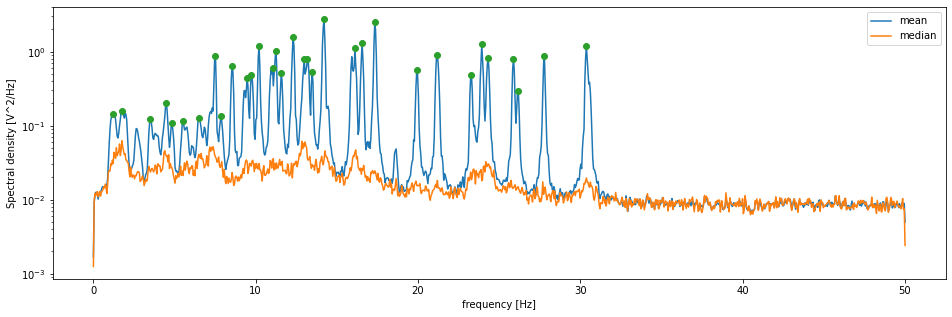

  --> The following peak frequencies were found: [ 1.22070312  1.7578125   3.515625    4.4921875   4.83398438  5.51757812
  6.49414062  7.51953125  7.86132812  8.54492188  9.47265625  9.71679688
 10.20507812 11.03515625 11.23046875 11.57226562 12.3046875  12.98828125
 13.18359375 13.4765625  14.20898438 16.11328125 16.55273438 17.33398438
 19.921875   21.19140625 23.29101562 23.92578125 24.31640625 25.87890625
 26.171875   27.78320312 30.37109375]
  --> Next analysis have to consider 33 frequency characteristics


In [196]:
from scipy import signal as sp
rcParams['figure.figsize'] = 16,5

# Calculating and plotting the spectral density by Welch transform:-------------------------------
window_size_welch=2048
f, Pxx_den = sp.welch(x=eeg_waves.signal, fs=1.0/settings.delta_t, nperseg=window_size_welch)
f_med, Pxx_den_med = sp.welch(x=eeg_waves.signal, fs=1.0/settings.delta_t, nperseg=window_size_welch, average='median')
plt.semilogy(f, Pxx_den, label='mean')
plt.semilogy(f_med, Pxx_den_med, label='median')
plt.xlabel('frequency [Hz]')
plt.ylabel('Spectral density [V^2/Hz]')
plt.legend()


# Finding spectral density maxima:----------------------------------------------------------------
delta_f = 1.0/(settings.delta_t*window_size_welch);
peak_indexes,peak_params = sp.find_peaks(x=Pxx_den, width=2, height=0.1)
peak_frequencies = peak_indexes*delta_f
plt.plot(peak_frequencies, peak_params['peak_heights'], "o")
plt.show()

n_spectral_features = peak_frequencies.shape[0]
print ("  --> The following peak frequencies were found: {}".format(peak_frequencies))
print ("  --> Next analysis have to consider {} frequency characteristics".format(n_spectral_features))

# ------------------------------------------------------------------------------------------------
# documents: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html#scipy.signal.find_peaks_cwt

  --> Power spectral density (51, 149271)
  --> Frequency axis (51,)
  --> Time axis (149271,)
  --> Power spectral density matrix [[1.19484155e-01 1.33055431e-01 1.35549528e-01 ... 8.66899029e-05
  1.13200560e-03 2.96725831e-03]
 [1.67630058e-01 1.80684758e-01 1.88427030e-01 ... 1.51474603e-03
  1.03603352e-03 1.26156774e-03]
 [1.43617963e-01 1.51206236e-01 1.58661288e-01 ... 3.66476244e-03
  3.55433772e-03 3.44055724e-03]
 ...
 [1.25845513e-03 1.39984025e-03 1.55830530e-03 ... 2.40103326e-03
  2.26853512e-03 2.14185204e-03]
 [1.46858837e-03 1.60848622e-03 1.75814257e-03 ... 1.71347568e-03
  1.58316588e-03 1.46044049e-03]
 [2.27382964e-04 1.72508593e-04 1.22227178e-04 ... 2.19500344e-04
  2.75816952e-04 3.33533569e-04]]


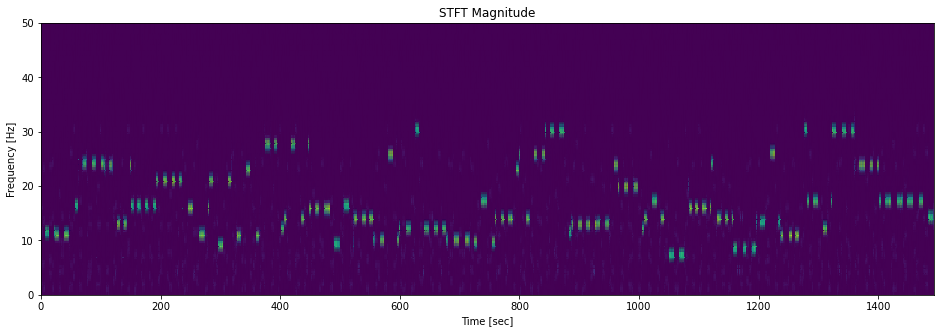

In [197]:

# Calculating the Fourier transform within the sliding window:----------------------------------
frequency_sampling = 1.0/settings.delta_t;
# Attention: 'settings.delta_t' and 'sliding_window_width' are selected according to the discritization
# frequency delta_f with in sliding window. The delta_f has to be equal to the 1 Hz.
delta_f = 1.0;
sliding_window_width = int(frequency_sampling/delta_f);


frequency_axis, time_axis, fourier_image_t = sp.stft(x=eeg_waves.signal,
                                                     fs=frequency_sampling,
                                                     nperseg=sliding_window_width,
                                                     detrend="constant",
                                                     noverlap=sliding_window_width-1)

power_spectral_density_t = np.abs(fourier_image_t)**2;
max_power_spectral_density = np.max(power_spectral_density_t);

print ("  --> Power spectral density {}".format(power_spectral_density_t.shape));
print ("  --> Frequency axis {}".format(frequency_axis.shape));
print ("  --> Time axis {}".format(time_axis.shape))
print ("  --> Power spectral density matrix {}".format(power_spectral_density_t));

plt.pcolormesh(time_axis, frequency_axis, power_spectral_density_t,
               vmin=0, vmax=max_power_spectral_density, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# documents: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html

In [198]:
#f, t, fourier_image_t_127 = sp.stft(x=eeg_waves.signal, fs=1.0/settings.delta_t, nperseg=128,detrend="constant",noverlap=127)
#power_spectral_density_t_127 = np.abs(fourier_image_t_127)**2;
#f, t, fourier_image_t_512 = sp.stft(x=eeg_waves.signal, fs=1.0/settings.delta_t, nperseg=512,detrend="constant",noverlap=511)
#power_spectral_density_t_512 = np.abs(fourier_image_t_512)**2;

#power_spectral_density_t = power_spectral_density_t_127*power_spectral_density_t_512


In [199]:
print ("  --> Temporal dependence of spectral density has the following shape={}".format(power_spectral_density_t.shape))

frequency_labels = [];

for i in range(0,frequency_axis.shape[0]):
    frequency_labels.append("f={}Hz".format(frequency_axis[i]));
    
print("  --> Made frequency_labels={}".format(frequency_labels));

  --> Temporal dependence of spectral density has the following shape=(51, 149271)
  --> Made frequency_labels=['f=0.0Hz', 'f=1.0Hz', 'f=2.0Hz', 'f=3.0Hz', 'f=4.0Hz', 'f=5.0Hz', 'f=6.0Hz', 'f=7.0Hz', 'f=8.0Hz', 'f=9.0Hz', 'f=10.0Hz', 'f=11.0Hz', 'f=12.0Hz', 'f=13.0Hz', 'f=14.0Hz', 'f=15.0Hz', 'f=16.0Hz', 'f=17.0Hz', 'f=18.0Hz', 'f=19.0Hz', 'f=20.0Hz', 'f=21.0Hz', 'f=22.0Hz', 'f=23.0Hz', 'f=24.0Hz', 'f=25.0Hz', 'f=26.0Hz', 'f=27.0Hz', 'f=28.0Hz', 'f=29.0Hz', 'f=30.0Hz', 'f=31.0Hz', 'f=32.0Hz', 'f=33.0Hz', 'f=34.0Hz', 'f=35.0Hz', 'f=36.0Hz', 'f=37.0Hz', 'f=38.0Hz', 'f=39.0Hz', 'f=40.0Hz', 'f=41.0Hz', 'f=42.0Hz', 'f=43.0Hz', 'f=44.0Hz', 'f=45.0Hz', 'f=46.0Hz', 'f=47.0Hz', 'f=48.0Hz', 'f=49.0Hz', 'f=50.0Hz']


In [200]:
# Making pandas data frame from transposed matrix of spectral dentsity
# and respective frequency labels:---------------------------------------------------

df = pd.DataFrame(data=power_spectral_density_t.T,columns=frequency_labels)

# Adding special column as the data frame target:------------------------------------
df["target"]=pd.Series(eeg_waves.target_signal)

# We do not consider ZERO frequecies. Let's remove this property:--------------------
df=df.drop(columns=["f=0.0Hz"])
df.info()
frequency_labels=frequency_labels[1:len(frequency_labels)]
print("  --> Made frequency_labels={}".format(frequency_labels));

# Nan controlling:-------------------------------------------------------------------
count_nan_in_df = df.isnull().sum().sum()
print ('  --> Original count of NaN: ' + str(count_nan_in_df))

# Deleting nan:----------------------------------------------------------------------
if count_nan_in_df>0:
    df = df.drop(df[df["target"].isnull()].index);
    count_nan_in_df = df.isnull().sum().sum()
    print ('  --> Residual count of NaN: ' + str(count_nan_in_df))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149271 entries, 0 to 149270
Data columns (total 51 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   f=1.0Hz   149271 non-null  float64
 1   f=2.0Hz   149271 non-null  float64
 2   f=3.0Hz   149271 non-null  float64
 3   f=4.0Hz   149271 non-null  float64
 4   f=5.0Hz   149271 non-null  float64
 5   f=6.0Hz   149271 non-null  float64
 6   f=7.0Hz   149271 non-null  float64
 7   f=8.0Hz   149271 non-null  float64
 8   f=9.0Hz   149271 non-null  float64
 9   f=10.0Hz  149271 non-null  float64
 10  f=11.0Hz  149271 non-null  float64
 11  f=12.0Hz  149271 non-null  float64
 12  f=13.0Hz  149271 non-null  float64
 13  f=14.0Hz  149271 non-null  float64
 14  f=15.0Hz  149271 non-null  float64
 15  f=16.0Hz  149271 non-null  float64
 16  f=17.0Hz  149271 non-null  float64
 17  f=18.0Hz  149271 non-null  float64
 18  f=19.0Hz  149271 non-null  float64
 19  f=20.0Hz  149271 non-null  float64
 20  f=21

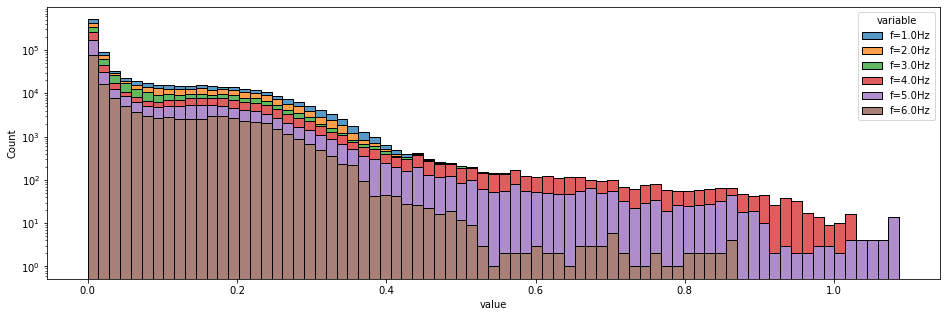

In [201]:
import seaborn as sb

sb.histplot(df[['f=1.0Hz', 'f=2.0Hz', 'f=3.0Hz', 'f=4.0Hz', 'f=5.0Hz', 'f=6.0Hz']].melt(), x='value', hue='variable',
             multiple='stack', shrink=1., bins=75,log_scale=[False,True]);


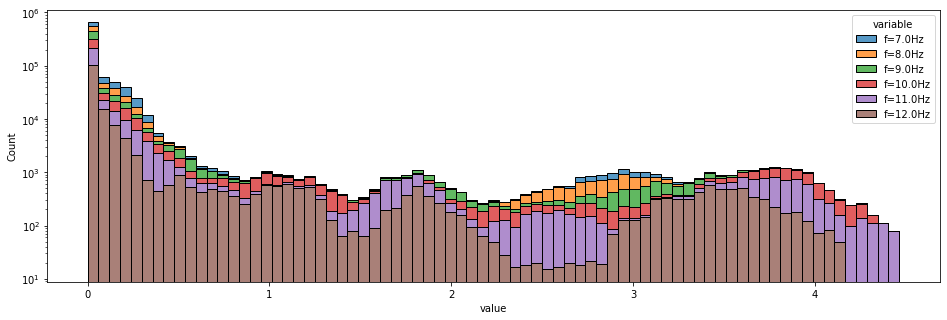

In [202]:
sb.histplot(df[['f=7.0Hz', 'f=8.0Hz', 'f=9.0Hz', 'f=10.0Hz', 'f=11.0Hz', 'f=12.0Hz']].melt(), x='value', hue='variable',
             multiple='stack', shrink=1., bins=75,log_scale=[False,True]);

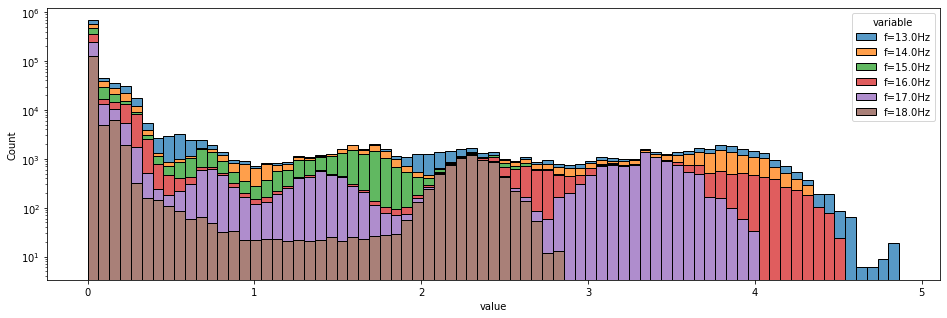

In [203]:
sb.histplot(df[['f=13.0Hz', 'f=14.0Hz', 'f=15.0Hz', 'f=16.0Hz', 'f=17.0Hz', 'f=18.0Hz']].melt(), x='value', hue='variable',
             multiple='stack', shrink=1., bins=75,log_scale=[False,True]);

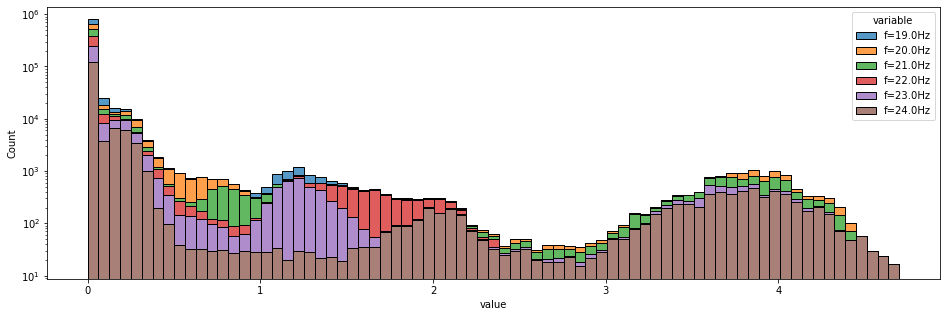

In [204]:
sb.histplot(df[['f=19.0Hz', 'f=20.0Hz', 'f=21.0Hz', 'f=22.0Hz', 'f=23.0Hz', 'f=24.0Hz']].melt(), x='value', hue='variable',
             multiple='stack', shrink=1., bins=75,log_scale=[False,True]);

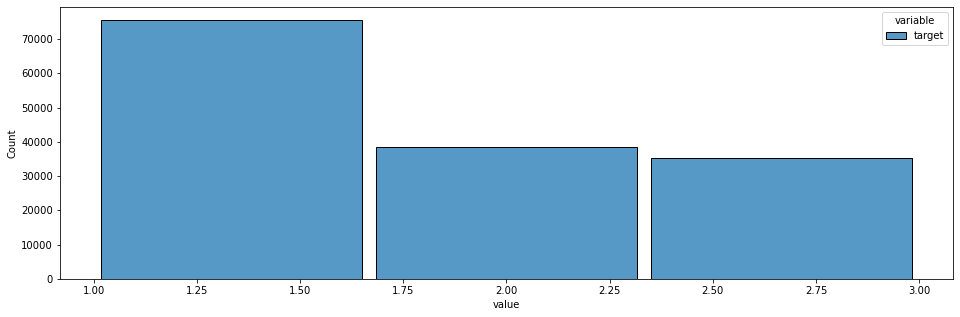

In [205]:
sb.histplot(df[['target']].melt(), x='value', hue='variable',
             multiple='stack', shrink=.95, bins=3,log_scale=False);

# Введение

На основе генератора мы получили data frame, состоящий из набора строк, каждая строка - это вектор. Координаты вектора это точки дискретизованного Фурье-спектра. По этим спектрам выделено 3 класса состояний при экспертной разметке. Набор векторов, уложенных в таблицу составляет данные в исследуемом data frame. Отдельной колонкой в data frame прописывается target. Эта колонка ставит в соответствие каждому вектору-строке его класс по экспертной разметке. Классов -три, поэтому и значения будут от 1 до 3 соответственно. Далее мы разобьем этот data frame на X и Y frame. В Х будут только вектора для классификации, как входные данные. По этим входным данным алгоритм классификации будет делать предположение о принадлежности объекта к определенному классу, выдавая его номер на выходе. В Y будут указания на правильные классы, по которым предполагается оценивать точность алгоритма классификации согласно экспертной разметке.

In [206]:
from sklearn.model_selection import train_test_split

# Создаем X ,Y для обучения и анализа:
X = pd.DataFrame(data=df,columns=frequency_labels);
Y = pd.DataFrame(data=df,columns=['target'])
X.info();
Y.info();

# Разделяем на тестовую и валидационную выборки:
# train---test----train-----test-----
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.25,shuffle=True)
print("X train shape={}".format(X_train.shape));
print("X test shape={}".format(X_test.shape));
print("Y train shape={}".format(Y_train.shape));
print("Y test shape={}".format(Y_test.shape));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149270 entries, 0 to 149269
Data columns (total 50 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   f=1.0Hz   149270 non-null  float64
 1   f=2.0Hz   149270 non-null  float64
 2   f=3.0Hz   149270 non-null  float64
 3   f=4.0Hz   149270 non-null  float64
 4   f=5.0Hz   149270 non-null  float64
 5   f=6.0Hz   149270 non-null  float64
 6   f=7.0Hz   149270 non-null  float64
 7   f=8.0Hz   149270 non-null  float64
 8   f=9.0Hz   149270 non-null  float64
 9   f=10.0Hz  149270 non-null  float64
 10  f=11.0Hz  149270 non-null  float64
 11  f=12.0Hz  149270 non-null  float64
 12  f=13.0Hz  149270 non-null  float64
 13  f=14.0Hz  149270 non-null  float64
 14  f=15.0Hz  149270 non-null  float64
 15  f=16.0Hz  149270 non-null  float64
 16  f=17.0Hz  149270 non-null  float64
 17  f=18.0Hz  149270 non-null  float64
 18  f=19.0Hz  149270 non-null  float64
 19  f=20.0Hz  149270 non-null  float64
 20  f=21

In [207]:
# Lets observe the first 1000 vectors:
X.head(1000)

,f=1.0Hz,f=2.0Hz,f=3.0Hz,f=4.0Hz,f=5.0Hz,f=6.0Hz,f=7.0Hz,f=8.0Hz,f=9.0Hz,f=10.0Hz,...,f=41.0Hz,f=42.0Hz,f=43.0Hz,f=44.0Hz,f=45.0Hz,f=46.0Hz,f=47.0Hz,f=48.0Hz,f=49.0Hz,f=50.0Hz
0,0.167630,0.143618,0.025975,0.033026,0.108866,0.083439,0.014003,0.001927,0.005916,0.027687,...,0.001013,0.000449,0.002087,0.001876,0.001742,0.001316,0.000025,0.001258,0.001469,0.000227
1,0.180685,0.151206,0.025287,0.033309,0.116067,0.089058,0.014052,0.001981,0.005613,0.028084,...,0.001055,0.000430,0.002251,0.001883,0.001765,0.001451,0.000010,0.001400,0.001608,0.000173
2,0.188427,0.158661,0.024659,0.033564,0.123365,0.094873,0.014089,0.002060,0.005294,0.028387,...,0.001103,0.000414,0.002426,0.001883,0.001779,0.001600,0.000006,0.001558,0.001758,0.000122
3,0.191670,0.165947,0.024104,0.033802,0.130721,0.100877,0.014127,0.002162,0.004961,0.028593,...,0.001159,0.000403,0.002611,0.001873,0.001786,0.001764,0.000015,0.001733,0.001919,0.000078
4,0.187038,0.173061,0.023623,0.034050,0.138052,0.107084,0.014179,0.002290,0.004611,0.028705,...,0.001224,0.000400,0.002803,0.001858,0.001784,0.001943,0.000040,0.001928,0.002090,0.000042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.004971,0.012119,0.001207,0.000364,0.004468,0.003844,0.003527,0.000597,0.003033,0.059637,...,0.002524,0.007534,0.019792,0.012260,0.000596,0.000160,0.002961,0.007188,0.002709,0.002315
996,0.007005,0.012425,0.001379,0.000406,0.004194,0.003891,0.003300,0.000824,0.002600,0.062535,...,0.002634,0.007574,0.019206,0.012059,0.000529,0.000127,0.002893,0.007222,0.003092,0.002631
997,0.012137,0.012704,0.001579,0.000469,0.003941,0.003919,0.003043,0.001076,0.002174,0.065312,...,0.002748,0.007573,0.018591,0.011870,0.000461,0.000095,0.002824,0.007236,0.003498,0.002967
998,0.014291,0.012932,0.001804,0.000548,0.003730,0.003912,0.002765,0.001338,0.001753,0.067870,...,0.002856,0.007547,0.017929,0.011710,0.000392,0.000065,0.002745,0.007241,0.003926,0.003309


In [208]:
# Lets observe the first 1000 classifiers:
Y.head(1000)

,target
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
995,3.0
996,3.0
997,3.0
998,3.0


In [209]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
    

# The basic method for lauching and calculating accuracy metrics:----------------
def execute_model (x_train,y_train,model,x_test,y_test):
    
    # FIT means learning:------------------------------------------ 
    model.fit(x_train,y_train)
    
    # Predict means analyzing test data:---------------------------
    y_predict = model.predict(x_test)
    
    # Accuracy metrics calculation:--------------------------------
    mse = mean_squared_error(y_test,y_predict)
    print("     > Mean squared error {}".format(mse))
    mae = mean_absolute_error(y_test,y_predict)
    print("     > Mean abs error {}".format(mae))
    
    # ATTENTION: Accuracy cannot be calculated for multiclass:
    try:
        accuracy = accuracy_score(y_test,y_predict)
        print ("     > Accuracy {}".format(accuracy))
    except:
        print("     > Accuracy was not calculated");
    try:
        confusion=confusion_matrix(y_test,y_predict)
        tp = confusion[1,1]
        tn = confusion[0,0]
        fp = confusion[0,1]
        fn = confusion[1,0]
        print ("     > TruePositive {} TrueNegative {} FalsePositive {} FalseNegative {}".format(tp,tn,fp,fn))
    except:
        print("     > Confusion was not calculated")
    
    r2s = r2_score(y_test,y_predict);
    print ("     > R2 = {}".format(r2s)); # 0 means bad , 1 means exceelent
    return y_predict;


# The basic function for executing scalers:--------------------------------------
def execute_scaling (x_train, scaler, x_test, make_data_frame):
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    if make_data_frame:
        x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
        x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns);
    
    return (x_train_scaled, x_test_scaled)
    

# Линейная регрессия

Применим модель линейной регрессии для задачи классификации по 3 классам из X и Y соответственно

In [210]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression();
execute_model(X_train,Y_train,lin_reg,X_test,Y_test)


     > Mean squared error 0.02392995598284566
     > Mean abs error 0.09644380590982708
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9642749479947713


array([[2.04140926],
       [1.08289047],
       [3.17285817],
       ...,
       [1.18594138],
       [1.01214208],
       [0.94600369]])

<b>Анализ коэффициентов линейной регрессии</b><br>
Рассмотрим коэффициенты полученной регрессии. Количественная оценка поможет определить необходимость масштабирования входных векторов.

In [211]:
lin_reg.intercept_ # free coefficient w0 from y=w0+w1x1+w2x2+..+wNxN

array([0.69856613])

In [212]:
lin_reg.coef_ # all coefficients from y=w0+w1x1+w2x2+..+wNxN except w0

array([[-0.12564389, -0.12098228, -0.15101494, -0.07526783,  0.18260007,
         0.06990031,  0.32874612,  0.40617167,  0.34660985,  0.38340551,
         0.35621581,  0.41769381,  0.29991939,  0.54584748, -0.02468062,
         0.28417846,  0.13842455,  0.30132733,  0.11736396,  0.24079699,
         0.204956  ,  0.20682107,  0.1983816 ,  0.207957  ,  0.21302594,
         0.2085515 ,  0.21227069,  0.20340025,  0.24913816,  0.20402866,
         0.21517734,  0.20111402, -0.07411219,  0.39916016, -0.40841445,
         0.00261815,  0.45690799, -0.01293046,  0.4402958 , -0.07728455,
         0.06315467,  0.26626081, -0.67493336,  0.48237846,  0.10190602,
         0.56795593,  0.11665802, -0.53181139,  0.14955534,  0.01610383]])

Все коэффициенты модели линейной регрессии соответствуют соответствующим параметрам анализиуруемой выборки. Поэтому столбчатая
диаграмма покажет их величину 

Text(0, 0.5, 'property')

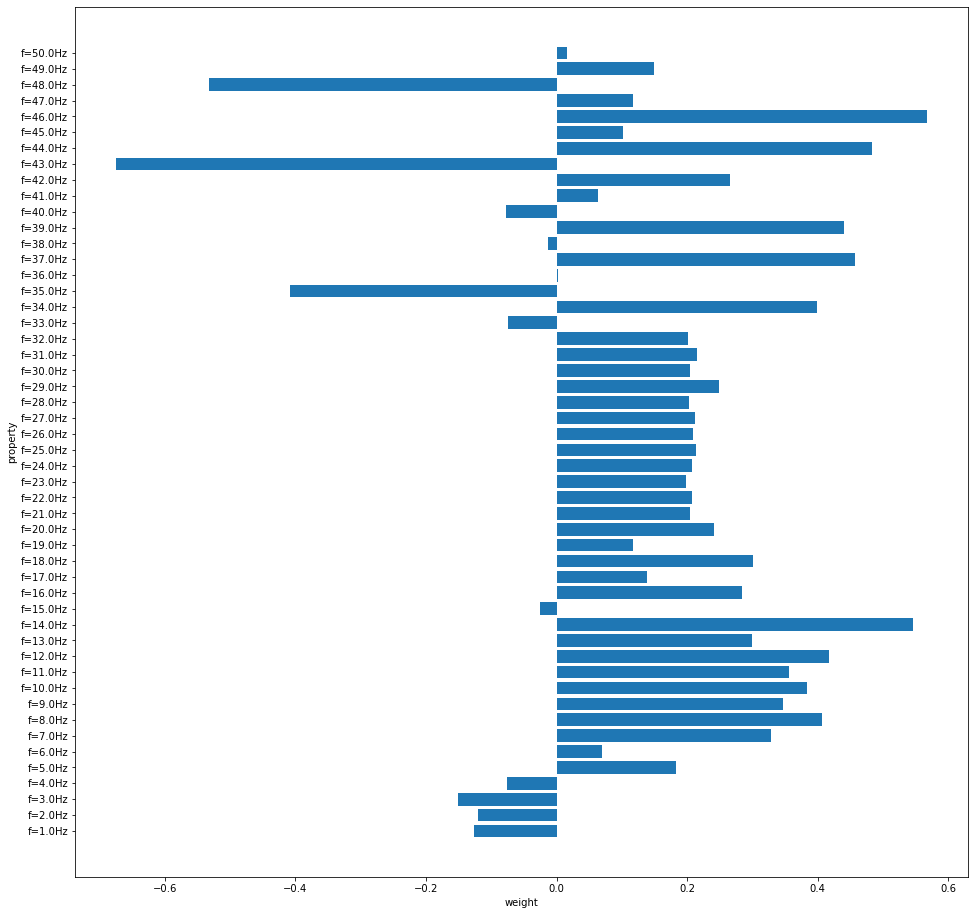

In [213]:

rcParams['figure.figsize'] = 16,16

plt.barh(X_train.columns,lin_reg.coef_.flatten())
plt.xlabel('weight')
plt.ylabel('property')

<b>Линейнай регрессия с масштабированием признаков</b>

In [214]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
#scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler();
scaler = MaxAbsScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,x_test=X_test,make_data_frame=True)

lin_reg = LinearRegression()
execute_model(X_train_scaler,Y_train,lin_reg,X_test_scaler,Y_test)


     > Mean squared error 0.023929955982845655
     > Mean abs error 0.096443805909827
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9642749479947713


array([[2.04140926],
       [1.08289047],
       [3.17285817],
       ...,
       [1.18594138],
       [1.01214208],
       [0.94600369]])

Text(0, 0.5, 'property')

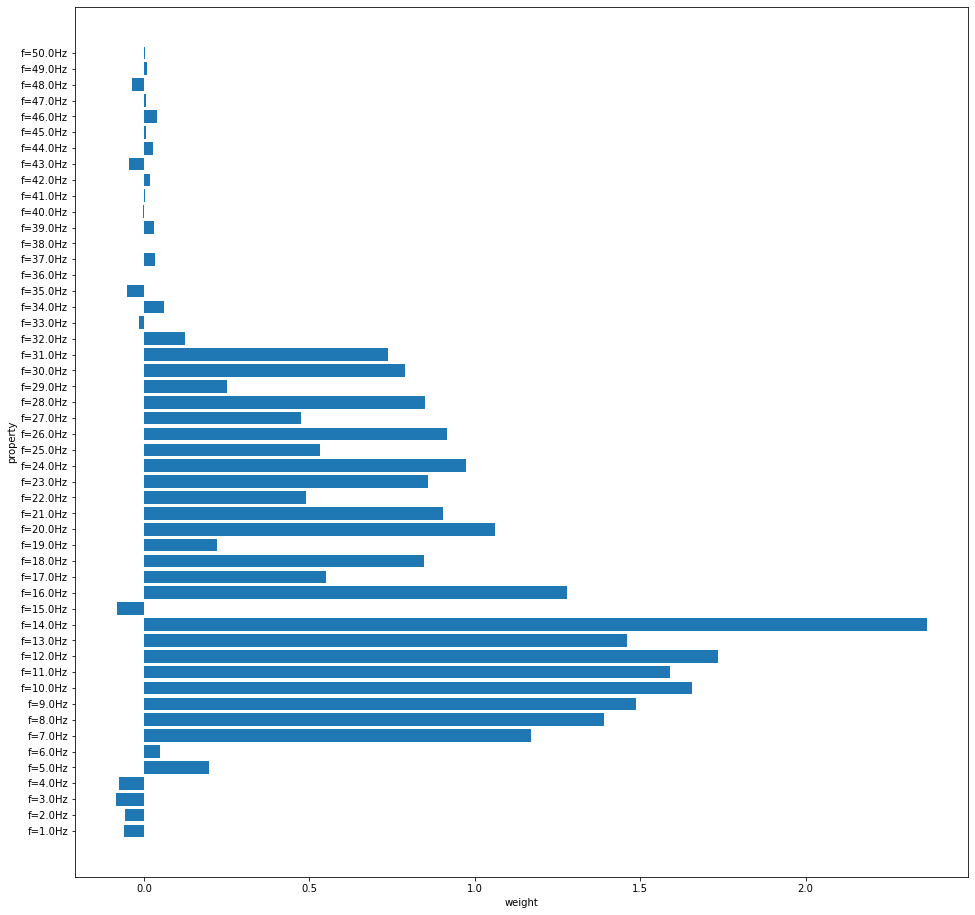

In [215]:
rcParams['figure.figsize'] = 16,16

plt.barh(X_train.columns,lin_reg.coef_.flatten())
plt.xlabel('weight')
plt.ylabel('property')

<b>Линейная регрессия с регуляризацией</b>

In [216]:
from sklearn.linear_model import Lasso

# Parameter ALPHA is responsible for regularisation
# The higher alpha - the stronger regularization and the lower overlearning
alpha_list = [0.01,0.001,0.0001,0.00001,0.000001];

for alpha in alpha_list:
    print ('  --> Lasso regularization {}'.format(alpha));
    execute_model(X_train,Y_train,Lasso(alpha=alpha),X_test,Y_test)


  --> Lasso regularization 0.01
     > Mean squared error 0.03840002225508158
     > Mean abs error 0.1415136789689426
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9426725735288379
  --> Lasso regularization 0.001
     > Mean squared error 0.024714161625316748
     > Mean abs error 0.09837934416104549
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9631042067121648
  --> Lasso regularization 0.0001
     > Mean squared error 0.023984507338635743
     > Mean abs error 0.09626616077022243
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9641935082284819
  --> Lasso regularization 1e-05
     > Mean squared error 0.023945512780709947
     > Mean abs error 0.09631584540617738
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9642517232377706
  --> Lasso regularization 1e-06
     > Mean squared error 0.023929590832911397
     > Mean abs error 0.09

In [217]:
from sklearn.linear_model import Ridge

alpha_list = [10.0,5.0,1.0,0.1,0.01,0.001,0.0001];

for alpha in alpha_list:
    print ('  --> Ridge regularization {}'.format(alpha));
    execute_model(X_train,Y_train,Ridge(alpha=alpha),X_test,Y_test)


  --> Ridge regularization 10.0
     > Mean squared error 0.0239576196254635
     > Mean abs error 0.09628106928635673
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9642336489187561
  --> Ridge regularization 5.0
     > Mean squared error 0.023950017374103513
     > Mean abs error 0.09629415445562683
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9642449983263933
  --> Ridge regularization 1.0
     > Mean squared error 0.02393384710690168
     > Mean abs error 0.09632831228735327
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9642691389322992
  --> Ridge regularization 0.1
     > Mean squared error 0.023928940641841954
     > Mean abs error 0.09641294703418453
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9642764637982347
  --> Ridge regularization 0.01
     > Mean squared error 0.02392977933707701
     > Mean abs error 0.096440000596

Масштабирование признаков не дало ощутимого прироста для решения этой задачи. Регуляризация подтвердила исходные цифры по точности, но дополнительных преимуществ не выявленно.

# Метод опорных векторов

Применим метод опорных векторов для задачи классификации по 3 классам из X и Y соответственно

In [218]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Support vector machine is sensible for non scaled data. That is why
# we have to use scaler
scaler = MinMaxScaler()
#scaler = RobustScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,
                                               x_test=X_test,make_data_frame=True);

#X_train_scaler.describe()

In [219]:
from sklearn.svm import SVC

c_param_values = np.linspace(start=0.1,stop=2.1, num=20)
for c_param in c_param_values:
    print("  --> Executing SVC with c={}".format(c_param))
    execute_model(X_train_scaler,Y_train["target"],SVC(C=c_param),X_test_scaler,Y_test["target"])


  --> Executing SVC with c=0.1
     > Mean squared error 0.007833644475806811
     > Mean abs error 0.004814520379087653
     > Accuracy 0.9966950416692719
     > TruePositive 28634 TrueNegative 56632 FalsePositive 74 FalseNegative 120
     > R2 = 0.988305145379737
  --> Executing SVC with c=0.20526315789473684
     > Mean squared error 0.006922547854903397
     > Mean abs error 0.004242851911069824
     > Accuracy 0.997096996060847
     > TruePositive 28653 TrueNegative 56628 FalsePositive 63 FalseNegative 101
     > R2 = 0.9896653223139068
  --> Executing SVC with c=0.31052631578947365
     > Mean squared error 0.00677963073789894
     > Mean abs error 0.0041177994336909236
     > Accuracy 0.9972131162184131
     > TruePositive 28667 TrueNegative 56616 FalsePositive 66 FalseNegative 88
     > R2 = 0.9898786834016197
  --> Executing SVC with c=0.4157894736842105
     > Mean squared error 0.006350879386885568
     > Mean abs error 0.0038498298393075665
     > Accuracy 0.997400694934481

# Алгоритм K- ближайших соседей (KNN)

Применим метод K- ближайших соседей для задачи классификации по 3 классам из X и Y соответственно

In [220]:

scaler = MinMaxScaler()
#scaler = RobustScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,
                                               x_test=X_test,make_data_frame=True);
#X_train_scaler.describe()

In [221]:
from sklearn.neighbors import KNeighborsClassifier

for n_neighbours in range(1,n_spectral_features):
    print("  --> Executing KNN n_neighbours={}".format(n_neighbours))
    execute_model(X_train_scaler,Y_train["target"],
                  KNeighborsClassifier(n_neighbors=n_neighbours),X_test_scaler,Y_test["target"])


  --> Executing KNN n_neighbours=1
     > Mean squared error 0.007771118237117362
     > Mean abs error 0.0046805355818959745
     > Accuracy 0.9968647557457148
     > TruePositive 28675 TrueNegative 56575 FalsePositive 92 FalseNegative 86
     > R2 = 0.9883984908556115
  --> Executing KNN n_neighbours=2
     > Mean squared error 0.010459746500763714
     > Mean abs error 0.0063330147472600105
     > Accuracy 0.9957303511294918
     > TruePositive 28552 TrueNegative 56674 FalsePositive 38 FalseNegative 209
     > R2 = 0.9843846353930127
  --> Executing KNN n_neighbours=3
     > Mean squared error 0.00909310156940859
     > Mean abs error 0.005627361482050504
     > Accuracy 0.9961055085616285
     > TruePositive 28644 TrueNegative 56532 FalsePositive 125 FalseNegative 117
     > R2 = 0.9864249007942671
  --> Executing KNN n_neighbours=4
     > Mean squared error 0.010182844586567577
     > Mean abs error 0.006306217787821675
     > Accuracy 0.9956320956115513
     > TruePositive 28551 

     > Mean squared error 0.014461425776888515
     > Mean abs error 0.008673282538207998
     > Accuracy 0.9942207890811322
     > TruePositive 28466 TrueNegative 56708 FalsePositive 28 FalseNegative 255
     > R2 = 0.9784105249370517


Метод SVC (опорных векторов) по сравнению с KNN (ближайшими соседями) показал более лучший результат в абсолютных значениях метрики r2-score 

# Деревья в решении задачи классификации

In [222]:
from sklearn.tree import DecisionTreeClassifier

for depth in range(1,n_spectral_features,1):
    print("  --> Executing DecisionTree depth={}".format(depth));
    execute_model(X_train,Y_train,
              DecisionTreeClassifier(max_depth=depth),X_test,Y_test)


  --> Executing DecisionTree depth=1
     > Mean squared error 0.4170678766982573
     > Mean abs error 0.4058310183737819
     > Accuracy 0.5997874107884559
     > TruePositive 28118 TrueNegative 39030 FalsePositive 17717 FalseNegative 643
     > R2 = 0.3773590057818508
  --> Executing DecisionTree depth=2
     > Mean squared error 0.2733289862710244
     > Mean abs error 0.25978758943485214
     > Accuracy 0.7469831089832341
     > TruePositive 27880 TrueNegative 55487 FalsePositive 1200 FalseNegative 881
     > R2 = 0.5919469197490927
  --> Executing DecisionTree depth=3
     > Mean squared error 0.1481067948156816
     > Mean abs error 0.13331487320572025
     > Accuracy 0.8740810875992604
     > TruePositive 27831 TrueNegative 55389 FalsePositive 1066 FalseNegative 604
     > R2 = 0.7788912377895328
  --> Executing DecisionTree depth=4
     > Mean squared error 0.058265522138754654
     > Mean abs error 0.04184791832286763
     > Accuracy 0.9663608835850759
     > TruePositive 279

     > Mean squared error 0.011013550329155986
     > Mean abs error 0.006672442900145597
     > Accuracy 0.9954981108143596
     > TruePositive 28647 TrueNegative 56480 FalsePositive 146 FalseNegative 110
     > R2 = 0.9835578611781252
  --> Executing DecisionTree depth=32
     > Mean squared error 0.011174332085786
     > Mean abs error 0.006922547854903397
     > Accuracy 0.9952033442605379
     > TruePositive 28624 TrueNegative 56474 FalsePositive 161 FalseNegative 117
     > R2 = 0.9833178299544482


<b>Ансамбли деревьев</b>

In [223]:
# Random forest . It's used an assembly of trees. The grouped trees are named as bagging.
# The quorum of groups are determined the class of the classified object
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = [{'n_estimators':[3,6,9],'max_features':np.arange(5,10),'max_depth':np.arange(5,15)}]

# n_estimators - is the number of trees 
# max_features - Max parameters per tree
# max_depth - max depth of the each tree
# grid search with cross validation. cv = 5. The first fourth groups (FOLDS) of the train set is used for FIT the last is used for vaidation
clf = GridSearchCV(estimator=RandomForestClassifier(random_state=100),param_grid=parameters,scoring='accuracy',cv=5)
clf.fit(X_train,Y_train["target"])

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid=[{'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                          'max_features': array([5, 6, 7, 8, 9]),
                          'n_estimators': [3, 6, 9]}],
             scoring='accuracy')

In [224]:

means=clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean,std,params in zip(means,stds,clf.cv_results_['params']):
    print("%0.5f (%0.05f) =>%r"%(mean,std*2,params))
    
    

0.90704 (0.00548) =>{'max_depth': 5, 'max_features': 5, 'n_estimators': 3}
0.92990 (0.03338) =>{'max_depth': 5, 'max_features': 5, 'n_estimators': 6}
0.96321 (0.00318) =>{'max_depth': 5, 'max_features': 5, 'n_estimators': 9}
0.93622 (0.01762) =>{'max_depth': 5, 'max_features': 6, 'n_estimators': 3}
0.95873 (0.01407) =>{'max_depth': 5, 'max_features': 6, 'n_estimators': 6}
0.96691 (0.01164) =>{'max_depth': 5, 'max_features': 6, 'n_estimators': 9}
0.96629 (0.00363) =>{'max_depth': 5, 'max_features': 7, 'n_estimators': 3}
0.96573 (0.01348) =>{'max_depth': 5, 'max_features': 7, 'n_estimators': 6}
0.97259 (0.00482) =>{'max_depth': 5, 'max_features': 7, 'n_estimators': 9}
0.94608 (0.00406) =>{'max_depth': 5, 'max_features': 8, 'n_estimators': 3}
0.96388 (0.00995) =>{'max_depth': 5, 'max_features': 8, 'n_estimators': 6}
0.98087 (0.01007) =>{'max_depth': 5, 'max_features': 8, 'n_estimators': 9}
0.95503 (0.00650) =>{'max_depth': 5, 'max_features': 9, 'n_estimators': 3}
0.97535 (0.00424) =>{'max

In [225]:
# selected the best params from the grid search:r
random_forest_classifier = RandomForestClassifier(max_depth=9,max_features=5,n_estimators=9)
execute_model(X_train,Y_train["target"],random_forest_classifier,X_test,Y_test["target"])


     > Mean squared error 0.010441881861138156
     > Mean abs error 0.00677963073789894
     > Accuracy 0.9950514948237207
     > TruePositive 28516 TrueNegative 56544 FalsePositive 104 FalseNegative 215
     > R2 = 0.9844113055289768


array([2., 1., 3., ..., 1., 1., 1.])

# Конвеерный алгоритм: АГК и деревья

In [226]:
# document source: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

from sklearn.decomposition import PCA


# Scaling:-------------------------------------------------------------
scaler = MinMaxScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,
                                               x_test=X_test,make_data_frame=False);


# Applying PCA:-------------------------------------------------------
pca = PCA (n_components=int(n_spectral_features/2));

X_train_pca=pca.fit_transform(X_train_scaler);
X_test_pca = pca.transform(X_test_scaler)

print("PCA explained variance {}".format(pca.explained_variance_ratio_))
print("X test PCA shape = {}".format(X_test_pca.shape))


# Executing decision tree with PCA:----------------------------------
for depth in range(1,n_spectral_features,1):
    print("  --> Executing DecisionTree depth={}".format(depth));
    execute_model(X_train_pca,Y_train,
              DecisionTreeClassifier(max_depth=depth),X_test_pca,Y_test)


PCA explained variance [0.10960618 0.09619852 0.07729182 0.06406138 0.05294505 0.04906775
 0.04233571 0.03928158 0.03726933 0.03633154 0.03443968 0.03097207
 0.02798496 0.02575443 0.0242455  0.02280338]
X test PCA shape = (111953, 16)
  --> Executing DecisionTree depth=1
     > Mean squared error 0.39815815565460505
     > Mean abs error 0.3326842514269381
     > Accuracy 0.7000527006868954
     > TruePositive 27978 TrueNegative 50395 FalsePositive 6352 FalseNegative 783
     > R2 = 0.40558934469986296
  --> Executing DecisionTree depth=2
     > Mean squared error 0.115575286057542
     > Mean abs error 0.09513813832590462
     > Accuracy 0.915080435539914
     > TruePositive 27310 TrueNegative 50353 FalsePositive 6012 FalseNegative 783
     > R2 = 0.8274575553801801
  --> Executing DecisionTree depth=3
     > Mean squared error 0.07722883710128357
     > Mean abs error 0.06856448688288835
     > Accuracy 0.9357676882263093
     > TruePositive 23877 TrueNegative 55598 FalsePositive 787

     > Mean squared error 0.009128830848659706
     > Mean abs error 0.005680955400927175
     > Accuracy 0.9960429823229391
     > TruePositive 28628 TrueNegative 56540 FalsePositive 117 FalseNegative 133
     > R2 = 0.986371560522339
  --> Executing DecisionTree depth=31
     > Mean squared error 0.009146695488285263
     > Mean abs error 0.005734549319803846
     > Accuracy 0.9959715237644369
     > TruePositive 28616 TrueNegative 56537 FalsePositive 115 FalseNegative 145
     > R2 = 0.9863448903863749
  --> Executing DecisionTree depth=32
     > Mean squared error 0.008896590533527463
     > Mean abs error 0.005573767563173832
     > Accuracy 0.996087643922003
     > TruePositive 28627 TrueNegative 56547 FalsePositive 118 FalseNegative 126
     > R2 = 0.9867182722898724


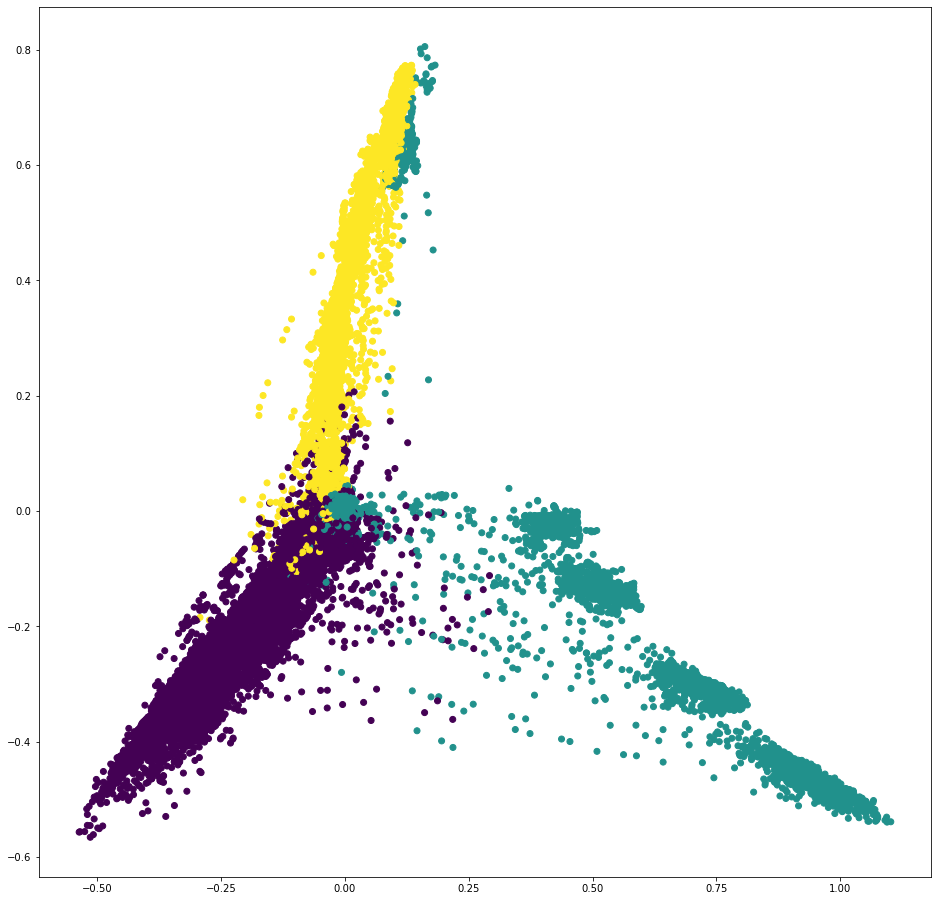

In [227]:
from sklearn.decomposition import PCA


# Reseaching PCA transform output:-----------------------------
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)

pca = PCA (n_components=33)
cluster = pca.fit_transform(X_train_scaler)
cluster2 = X_train_scaler @ pca.components_.T

i1 = 0;
i2 = 1;

x=cluster[0:cluster.shape[0],i1:i1+1];
y=cluster[0:cluster.shape[0],i2:i2+1];
x1=cluster2[0:cluster2.shape[0],i1:i1+1];
y1=cluster2[0:cluster2.shape[0],i2:i2+1];

#plt.scatter(x,y,c=Y_train["target"]);
plt.scatter(x1,y1,c=Y_train["target"]);



Дополнительный АГК к дереву решений планировался как алгоритм предварительного сжатия и сглаживания. В задачах классификации
зашумленных данных это совсем не лишняя процедура. Однако в данном случае этот подход проигрывает простому дереву решений. На рисунке выше показан кластер из разложений по первым двум компонентам. Это максимум информации о разделимости объектов в пространстве. Наиболее проблемные участки находятся на пересечении кластеров. Дерево решиений в представлении АГК работает хуже чем без него.

# Метод стохастического обобщения соседей (обзор)

In [228]:
from sklearn.manifold import TSNE

# document source: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# scaling:----------------------------------------------------------------
#scaler=StandardScaler()

#X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,
                                   #            x_test=X_test,make_data_frame=True);



# learning rate influences on cluster density:---------------------------
#tsne = TSNE(n_components=2,
#            learning_rate=1000,
#            random_state=100,
#            #method='exact',
#            verbose=1
#           )
#X_train_tsne = tsne.fit_transform(X_train_scaler)

#plt.scatter(X_train_tsne[:,0],X_train_tsne[:,1],c=Y_train["target"])





In [229]:
#tsne2 = TSNE(n_components=2,
#            learning_rate=10,
#            random_state=100,
#            #method='exact',
#            verbose=1
#           )
#X_test_tsne = tsne2.fit_transform(X_test_scaler)

#plt.scatter(X_test_tsne[:,0],X_test_tsne[:,1],c=Y_test["target"])


In [230]:
#from sklearn.cluster import KMeans
#from sklearn.cluster import BisectingKMeans

#kMeans = KMeans(n_clusters=20)
#X_train_kmeans = MinMaxScaler().fit_transform(X_train_kmeans);
#X_train_kmeans = kMeans.fit_transform(X_train_kmeans)
#plt.scatter(X_train_kmeans[:,0],X_train_kmeans[:,1],c=Y_train["target"])

TSNE алгоритм довольно бесполезный для такого круга задач.<br>
1. Кластеры разделяются, но при этом геометрически они не различимы<br>
2. Плотность точек в кластерах не имеет хорошо выделенных максимумов<br>
3. В зависимости от данных и от количественных характеристик результат получается довольно сильно прыгающим<br>
4. Метод плохо сопрягается с каким-либо другим кластерным алгоритмом, чтобы устранить проблемы 1 - 3<br>

Общий вывод: Этот алгоритм хорош для представления данных нежели для анализа.

# Конвеерный алгоритм: Масштабирование + сжатие + кластеризация + классификация

Рассматривается комбинированный алгоритм, который опционально включает:<br>
1) масштабирование<br>
2) сжатие на основе АГК<br>
3) кластеризация пространства признаков на основе k-среднего<br>
4) построение классификации<br>
    
Количество кластеров и классов на стадии 3 и 4 мы ставим 3, потому что исходная задача имеет объекты трех классов.
Количество компонент сжатия мы устанавливаем на уровне чуть превышающеми количество гармоник в Фурье-спектре (см. выше).


In [231]:

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering.fit
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.BisectingKMeans.html#sklearn.cluster.BisectingKMeans.fit_transform
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.fit
from sklearn.cluster import KMeans
from sklearn.cluster import BisectingKMeans

enable_scaler=False

enable_pca=True
n_components_pca = 17

enable_bis_kmeans=False
enable_kmeans=False
n_clusters_kmeans = 3

n_neigbours_knn = 3
X_train_exp=X_train;
X_test_exp=X_test;

if enable_scaler:
    print("  --> Executing min/max scaler")
    scaler = MinMaxScaler()
    X_train_exp = scaler.fit_transform(X_train_exp)
    X_test_exp = scaler.transform(X_test_exp)

if enable_pca:
    print("  --> PCA: n_components={}".format(n_components_pca))
    pca = PCA (n_components=n_components_pca)
    X_train_exp = pca.fit_transform(X_train_exp)
    X_test_exp = pca.transform(X_test_exp)
    
if enable_bis_kmeans:
    print("  --> Bisecting K means: n_clusters={}".format(n_clusters_kmeans))
    kMeans = BisectingKMeans(n_clusters=n_clusters_kmeans)
    X_train_exp = kMeans.fit_transform(X_train_exp)
    X_test_exp = kMeans.transform(X_test_exp);
    
if enable_kmeans:
    print("  --> K means: n_clusters={}".format(n_clusters_kmeans))
    kMeans = KMeans(n_clusters=n_clusters_kmeans)
    X_train_exp = kMeans.fit_transform(X_train_exp)
    X_test_exp = kMeans.transform(X_test_exp);

print("  --> KNN n_neigbours={}".format(n_neigbours_knn))
knn = KNeighborsClassifier(n_neighbors=n_neigbours_knn);
execute_model(X_train_exp,Y_train["target"],knn,X_test_exp,Y_test["target"])



  --> PCA: n_components=17
  --> KNN n_neigbours=3
     > Mean squared error 0.006136503711378883
     > Mean abs error 0.003778371280805338
     > Accuracy 0.9974006949344815
     > TruePositive 28677 TrueNegative 56613 FalsePositive 72 FalseNegative 74
     > R2 = 0.9908388082963276


array([2., 1., 3., ..., 1., 1., 1.])